In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import os
plt.rcParams['font.family'] = 'AppleGothic' 
plt.rcParams['axes.unicode_minus'] = False
import koreanize_matplotlib

In [2]:
votes_df = pd.read_parquet("/home/sprintda05/final/parquet/accounts_userquestionrecord.parquet")
users_df = pd.read_parquet("/home/sprintda05/final/parquet/accounts_user.parquet")
school_df = pd.read_parquet("/home/sprintda05/final/parquet/accounts_group.parquet")

In [3]:
#  유효한 group_id (school_id 존재) 필터
valid_groups = school_df[school_df["school_id"].notnull()]["id"]
active_users = users_df[
    (users_df["created_at"] < "2023-08-01") &
    (users_df["group_id"].isin(valid_groups))
]

In [4]:
#  5–7월 투표 
votes = votes_df[
    (votes_df["created_at"] >= "2023-05-01") &
    (votes_df["created_at"] < "2023-08-01")
].copy()

In [5]:
# 해당 학교 투표 유저만 선별
school_ids = (
    active_users[active_users["id"].isin(votes["user_id"])]
    .merge(school_df.rename(columns={"id":"group_id"})[["group_id","school_id"]], on="group_id", how="left")["school_id"]
    .dropna().unique()
)
target_ids = active_users.merge(
    school_df.rename(columns={"id":"group_id"})[["group_id","school_id"]],
    on="group_id", how="left"
).query("school_id in @school_ids")["id"].unique()
votes = votes[votes["user_id"].isin(target_ids)].copy()

In [6]:
# vote_date, cohort_day, active_day 컬럼 생성
votes["vote_date"] = pd.to_datetime(votes["created_at"]).dt.normalize()
cohort = votes.groupby("user_id")["vote_date"].min().reset_index(name="cohort_day")
votes = votes.merge(cohort, on="user_id")
votes["active_day"] = (votes["vote_date"] - votes["cohort_day"]).dt.days
votes = votes[(votes["active_day"] >= 0) &
              (votes["cohort_day"] >= "2023-05-01") &
              (votes["cohort_day"] <= "2023-05-25")]

In [7]:
# cohort_size 및 retained count (nunique 기준)
cohort_size = votes.groupby("cohort_day")["user_id"].nunique().reset_index(name="cohort_size")
retained = votes.groupby(["cohort_day", "active_day"])["user_id"].nunique().reset_index(name="retained")


In [8]:
# 리텐션율 계산
ret = retained.merge(cohort_size, on="cohort_day")
ret["rate"] = ret["retained"] / ret["cohort_size"]


In [9]:
# 히트맵용 피벗 (Day 0–25)
heat = ret.pivot(index="cohort_day", columns="active_day", values="rate").fillna(0)
heat_10 = heat.loc[:, :25]


In [10]:
# 5~7월 투표 기록 필터 (이미 target_ids 기준 필터링된 votes 사용)
daily_voters = votes.groupby("vote_date")["user_id"] \
    .nunique().reset_index(name="daily_voter_count")


/tmp/ipykernel_308728/2484358027.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot = heat_10.applymap(lambda x: f"{x:.1%}")


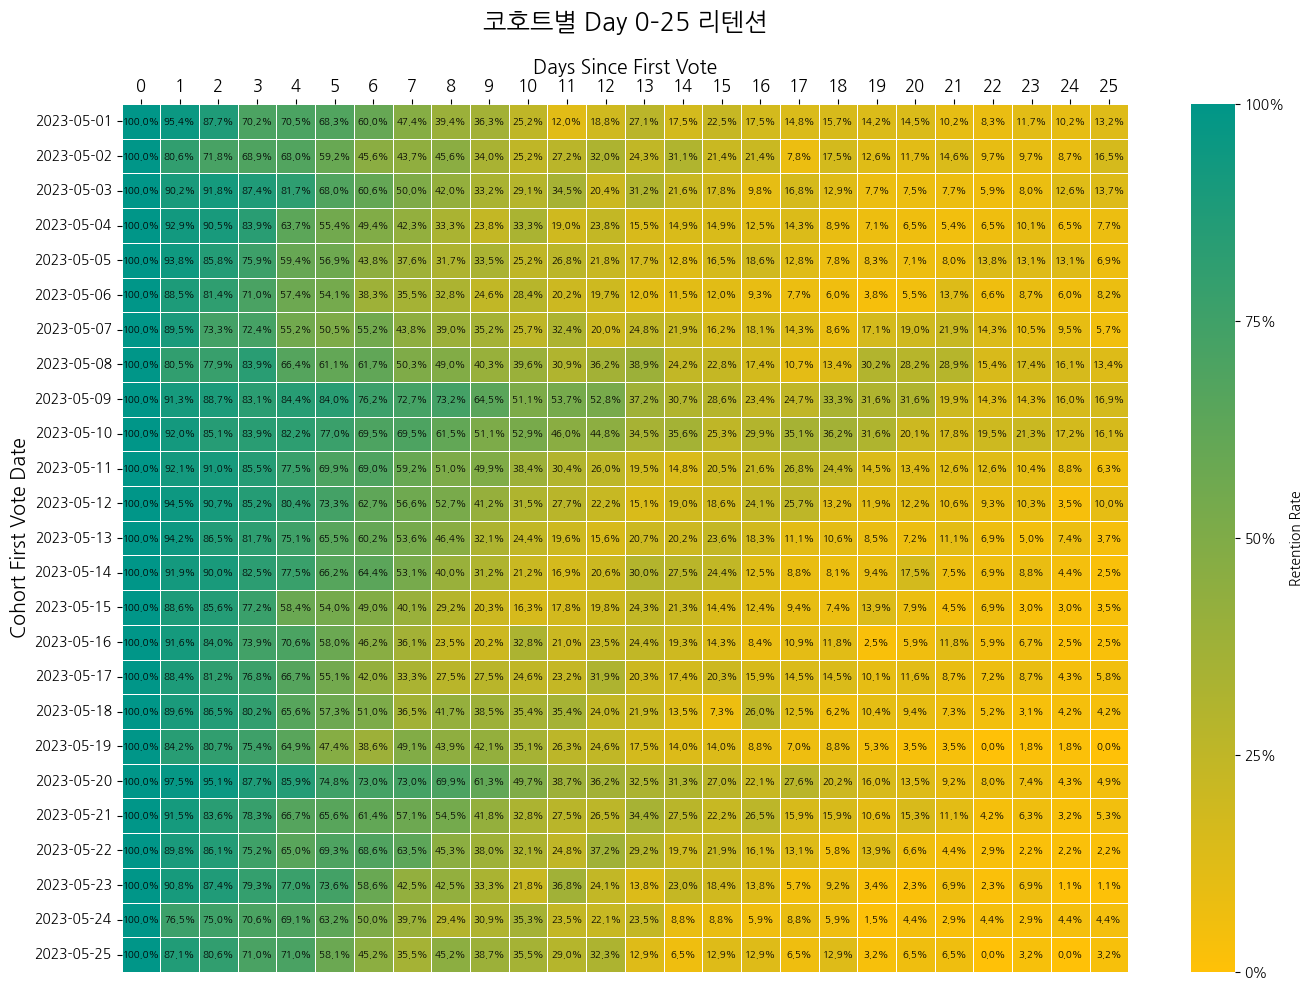

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib import ticker

# 컬러맵
custom_cmap = mcolors.LinearSegmentedColormap.from_list(
    "team_palette", ["#ffc107","#009688"], N=256
)

# annot 포멧팅
annot = heat_10.applymap(lambda x: f"{x:.1%}")

# 히트맵 생성
plt.figure(figsize=(14, 10))
ax = sns.heatmap(
    heat_10,
    cmap=custom_cmap,
    annot=annot,
    fmt="",
    annot_kws={"size": 7, "color": "black"},
    linewidths=0.5,
    linecolor="white",
    vmin=0, vmax=1,
    cbar_kws={
        "label": "Retention Rate",
        "format": ticker.PercentFormatter(xmax=1, decimals=0),
        "ticks": [0, .25, .5, .75, 1]
    }
)

# 축과 레이블 설정
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
plt.xticks(rotation=0, fontsize=12)

new_ylabels = [idx.split('T')[0] for idx in heat_10.index.astype(str)]
ax.set_yticklabels(new_ylabels, rotation=0, fontsize=10)

# 타이틀 및 라벨 설정
plt.title("코호트별 Day 0–25 리텐션", fontsize=18, pad=20)
plt.xlabel("Days Since First Vote", fontsize=14)
plt.ylabel("Cohort First Vote Date", fontsize=14)

plt.tight_layout()
plt.show()


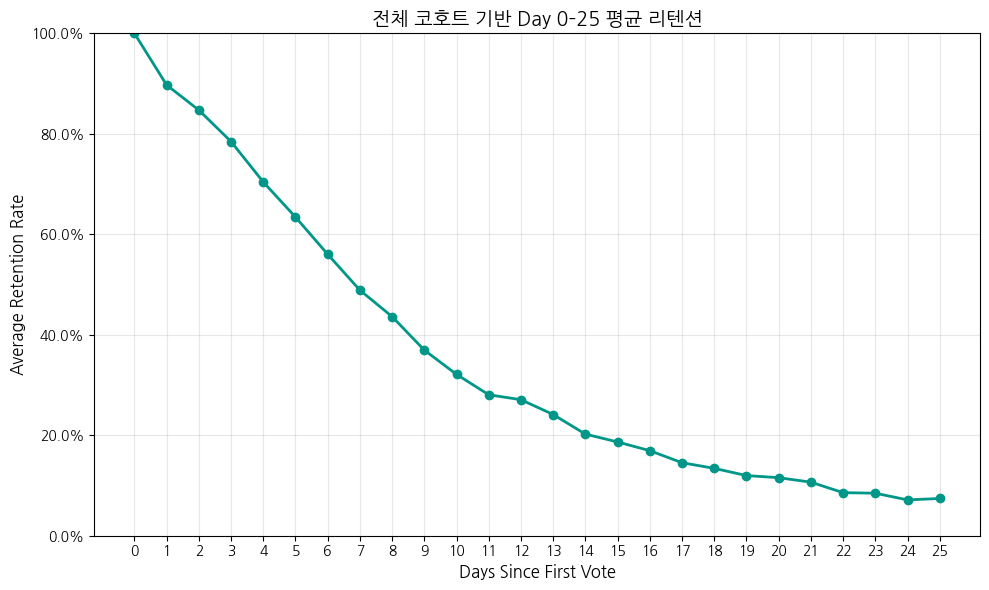

In [12]:
import matplotlib.pyplot as plt

# 1. active_day별 평균 리텐션율 계산
avg_retention = (
    ret[ret["active_day"] <= 25]  # Day 0~25 기준
    .groupby("active_day")["rate"]
    .mean()
    .reset_index()
)

# 2. 라인 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(
    avg_retention["active_day"],
    avg_retention["rate"],
    marker="o",
    color="#009688",  # 팀 청록색
    linewidth=2
)

# 3. 라벨, 그리드, 눈금 설정
plt.xticks(range(0, 26, 1))
plt.xlabel("Days Since First Vote", fontsize=12)
plt.ylabel("Average Retention Rate", fontsize=12)
plt.title("전체 코호트 기반 Day 0–25 평균 리텐션", fontsize=14)
plt.grid(alpha=0.3)
plt.ylim(0, 1)

# 4. y축 값 퍼센트 형식으로 변환
from matplotlib import ticker
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1))

plt.tight_layout()
plt.show()



In [13]:
avg_retention

,active_day,rate
0,0,1.000000
1,1,0.897196
2,2,0.847152
3,3,0.784499
4,4,0.704075
5,5,0.634293
6,6,0.560151
7,7,0.488751
8,8,0.436079
9,9,0.369450


In [14]:
cohort_size.set_index('cohort_day')

,cohort_size
cohort_day,
2023-05-01,325
2023-05-02,103
2023-05-03,388
2023-05-04,168
2023-05-05,436
2023-05-06,183
2023-05-07,105
2023-05-08,149
2023-05-09,231


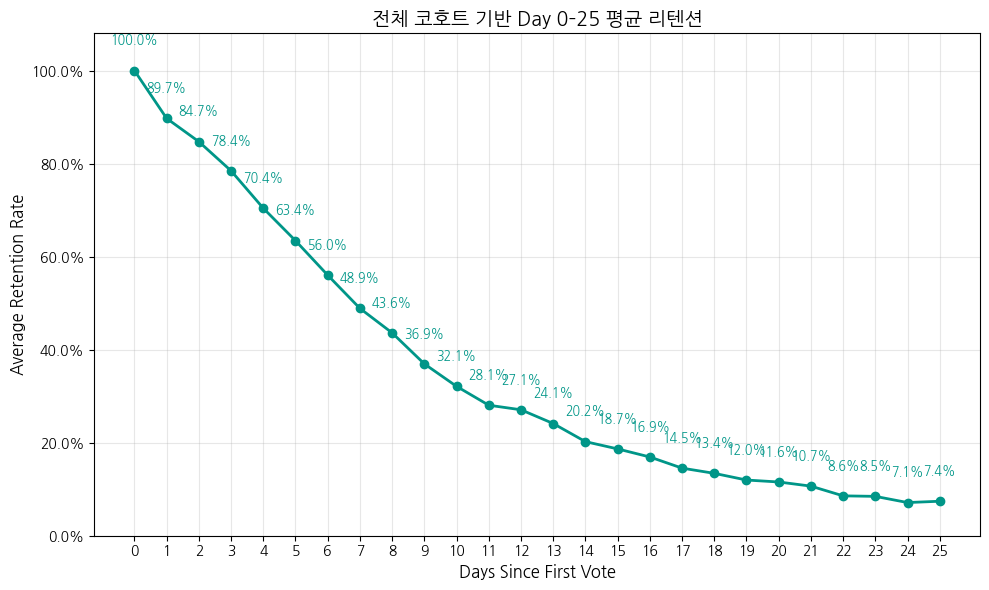

In [13]:
# 수치 추가 후 조절

from matplotlib import ticker

# 1. 평균 리텐션 계산 (Day 0~25)
avg_retention = (
    ret[ret["active_day"] <= 25]
    .groupby("active_day")["rate"]
    .mean()
    .reset_index()
)

# 2. 라인 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(
    avg_retention["active_day"],
    avg_retention["rate"],
    marker="o",
    color="#009688",  # 팀 청록색
    linewidth=2,
    label="평균 리텐션율"
)

# 3. 각 점 위에 수치 표시
# 수치 표시를 좀 더 보기 좋게 띄워서 추가
for x, y in zip(avg_retention["active_day"], avg_retention["rate"]):
    plt.text(x, y + 0.05, f"{y:.1%}", ha="center", va="bottom", fontsize=9, color="#009688")



# 4. 레이블/그리드/포맷 설정
plt.xticks(range(0, 26))
plt.xlabel("Days Since First Vote", fontsize=12)
plt.ylabel("Average Retention Rate", fontsize=12)
plt.title("전체 코호트 기반 Day 0–25 평균 리텐션", fontsize=14)
plt.grid(alpha=0.3)
plt.ylim(0, 1.08)
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1))
plt.tight_layout()
plt.show()


# 코호트 집단 별 행동/속성 비교

In [14]:
# 분석 대상 두 코호트 유저 추출
target_days = ["2023-05-17", "2023-05-20"]
target_users_df = cohort[cohort["cohort_day"].isin(pd.to_datetime(target_days))].copy()

# 유저 ID 목록 추출
users_0517 = target_users_df[target_users_df["cohort_day"] == "2023-05-17"]["user_id"].unique()
users_0520 = target_users_df[target_users_df["cohort_day"] == "2023-05-20"]["user_id"].unique()

print(" 5/17 유저 수:", len(users_0517))
print(" 5/20 유저 수:", len(users_0520))

 5/17 유저 수: 69
 5/20 유저 수: 163


In [18]:
# 데이터 프레임 가공

In [15]:
# 1. 유저 기본 정보
user_meta_df = users_df[["id", "gender", "group_id"]].rename(columns={"id": "user_id"})

# 2. school_df에서 group_id 기준 school_id, grade 붙이기
school_info_df = school_df.rename(columns={"id": "group_id"})[["group_id", "school_id", "grade"]]

# 3. 병합
user_meta_df = user_meta_df.merge(school_info_df, on="group_id", how="left")


In [20]:
user_meta_df

,user_id,gender,group_id,school_id,grade
0,831956,None,NaN,NaN,NaN
1,831962,F,12.0,1.0,2.0
2,832151,M,1.0,1.0,1.0
3,832340,F,1.0,1.0,1.0
4,832520,M,12.0,1.0,2.0
...,...,...,...,...,...
677080,1583729,M,32442.0,2389.0,3.0
677081,1583730,M,43949.0,2969.0,3.0
677082,1583731,M,18640.0,2579.0,3.0
677083,1583732,F,18640.0,2579.0,3.0


In [16]:
# 집단별 유저 메타 정보 추출
user_0517_df = user_meta_df[user_meta_df["user_id"].isin(users_0517)].copy()
user_0520_df = user_meta_df[user_meta_df["user_id"].isin(users_0520)].copy()

# 성별 비율 계산
gender_0517 = user_0517_df["gender"].value_counts(normalize=True).rename("0517")
gender_0520 = user_0520_df["gender"].value_counts(normalize=True).rename("0520")

# 비교용 데이터프레임 병합
gender_compare = pd.concat([gender_0517, gender_0520], axis=1).fillna(0)
gender_compare = gender_compare.reset_index().rename(columns={"index": "gender"})

display(gender_compare)


,gender,0517,0520
0,F,0.507246,0.533742
1,M,0.492754,0.466258


In [17]:
user_0517_df

,user_id,gender,group_id,school_id,grade
50453,899988,M,15646.0,5520.0,3.0
221862,1084952,F,16231.0,5491.0,1.0
242811,1107731,M,36505.0,5520.0,3.0
287502,1156188,F,5184.0,5491.0,2.0
297638,1167130,F,47738.0,5372.0,3.0
...,...,...,...,...,...
473142,1359366,F,63325.0,1719.0,3.0
473683,1359977,F,56038.0,1719.0,2.0
473821,1360136,M,56038.0,1719.0,2.0
473895,1360216,M,52247.0,1719.0,3.0


In [18]:
user_0520_df

,user_id,gender,group_id,school_id,grade
13343,855230,M,5545.0,4426.0,1.0
31840,878156,F,9568.0,4516.0,1.0
34356,881242,F,11395.0,4426.0,1.0
35669,882900,F,11843.0,4426.0,1.0
35873,883165,F,11909.0,4426.0,1.0
...,...,...,...,...,...
521070,1412867,M,56013.0,4426.0,1.0
521410,1413257,M,11395.0,4426.0,1.0
521446,1413294,F,70737.0,4426.0,3.0
521702,1413576,M,70559.0,4426.0,3.0


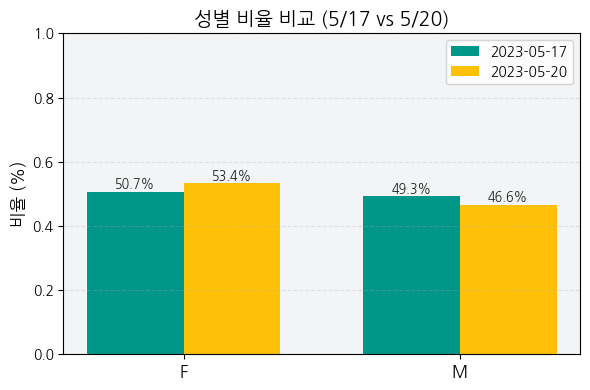

In [19]:
import matplotlib.pyplot as plt

# 스타일 설정
plt.figure(figsize=(6, 4))
bar_width = 0.35
x = range(len(gender_compare))

# 막대 그래프
plt.bar(
    [i - bar_width/2 for i in x],
    gender_compare["0517"],
    width=bar_width,
    label="2023-05-17",
    color="#009688"
)
plt.bar(
    [i + bar_width/2 for i in x],
    gender_compare["0520"],
    width=bar_width,
    label="2023-05-20",
    color="#ffc107"
)

# 수치 라벨 (막대 위에 표시)
for i in x:
    plt.text(i - bar_width/2, gender_compare["0517"][i] + 0.01,
             f'{gender_compare["0517"][i]*100:.1f}%', ha='center', fontsize=9, color="#1a1a1a")
    plt.text(i + bar_width/2, gender_compare["0520"][i] + 0.01,
             f'{gender_compare["0520"][i]*100:.1f}%', ha='center', fontsize=9, color="#1a1a1a")

# 축 및 제목
plt.xticks(x, gender_compare["gender"], fontsize=12)
plt.ylabel("비율 (%)", fontsize=12)
plt.title("성별 비율 비교 (5/17 vs 5/20)", fontsize=14)
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.gca().set_facecolor("#f2f4f5")  # 배경색

plt.tight_layout()
plt.show()



# 투표 대상 수
유저가 **몇 명에게 질문(투표)**을 보냈는지 측정

votes_df에서 user_id가 보낸 질문 중 고유 chosen_user_id 수를 계산

In [20]:
# 유저별로 보낸 질문의 대상 수 계산
vote_target_cnt_df = votes_df.groupby("user_id")["chosen_user_id"].nunique().reset_index()
vote_target_cnt_df.rename(columns={"chosen_user_id": "vote_target_cnt"}, inplace=True)


In [21]:
user_meta_df = user_meta_df.merge(vote_target_cnt_df, on="user_id", how="left")


In [22]:
user_meta_df["vote_target_cnt"] = user_meta_df["vote_target_cnt"].fillna(0).astype(int)


In [23]:
user_meta_df

,user_id,gender,group_id,school_id,grade,vote_target_cnt
0,831956,None,NaN,NaN,NaN,0
1,831962,F,12.0,1.0,2.0,0
2,832151,M,1.0,1.0,1.0,0
3,832340,F,1.0,1.0,1.0,0
4,832520,M,12.0,1.0,2.0,0
...,...,...,...,...,...,...
677080,1583729,M,32442.0,2389.0,3.0,0
677081,1583730,M,43949.0,2969.0,3.0,0
677082,1583731,M,18640.0,2579.0,3.0,0
677083,1583732,F,18640.0,2579.0,3.0,0


# 유저별 친구 수 
유저가 가진 친구 수를 계산



In [24]:
friends_df = pd.read_parquet("/home/sprintda05/final/parquet/accounts_friendrequest.parquet")

In [25]:
# 1. 양방향 친구 관계로 펼치기
friends_all_df = pd.concat([
    friends_df[["send_user_id", "receive_user_id"]].rename(columns={"send_user_id": "user_id", "receive_user_id": "friend_id"}),
    friends_df[["receive_user_id", "send_user_id"]].rename(columns={"receive_user_id": "user_id", "send_user_id": "friend_id"})
])

# 2. 유저별 친구 수 세기
friend_cnt_df = friends_all_df.groupby("user_id")["friend_id"].nunique().reset_index()
friend_cnt_df.rename(columns={"friend_id": "friend_cnt"}, inplace=True)


In [26]:
user_meta_df = user_meta_df.merge(friend_cnt_df, on="user_id", how="left")
user_meta_df["friend_cnt"] = user_meta_df["friend_cnt"].fillna(0).astype(int)


# 유저별 신고한 사람 수
각 유저가 몇 명을 신고했는지 계산

In [27]:
reports_df = pd.read_parquet("/home/sprintda05/final/parquet/accounts_timelinereport.parquet")

In [28]:
# 1. 유저별로 신고한 고유 인원 수 계산
report_cnt_df = reports_df.groupby("user_id")["reported_user_id"].nunique().reset_index()
report_cnt_df.rename(columns={"reported_user_id": "report_cnt"}, inplace=True)


In [29]:
user_meta_df = user_meta_df.merge(report_cnt_df, on="user_id", how="left")
user_meta_df["report_cnt"] = user_meta_df["report_cnt"].fillna(0).astype(int)


In [30]:
user_meta_df

,user_id,gender,group_id,school_id,grade,vote_target_cnt,friend_cnt,report_cnt
0,831956,None,NaN,NaN,NaN,0,0,0
1,831962,F,12.0,1.0,2.0,0,27,0
2,832151,M,1.0,1.0,1.0,0,45,0
3,832340,F,1.0,1.0,1.0,0,51,0
4,832520,M,12.0,1.0,2.0,0,14,0
...,...,...,...,...,...,...,...,...
677080,1583729,M,32442.0,2389.0,3.0,0,0,0
677081,1583730,M,43949.0,2969.0,3.0,0,22,0
677082,1583731,M,18640.0,2579.0,3.0,0,3,0
677083,1583732,F,18640.0,2579.0,3.0,0,3,0


# 이성에게 받은 투표 수
각 유저가 이성에게 받은 투표 수 계산
→ 즉, 자신에게 투표한 유저가 다른 성별일 때만 카운트

In [31]:
votes_with_user_gender = votes_df.merge(
    user_meta_df[["user_id", "gender"]],
    on="user_id",
    how="left"
).rename(columns={"gender": "user_gender"})

In [32]:
votes_with_both_gender = votes_with_user_gender.merge(
    user_meta_df[["user_id", "gender"]],
    left_on="chosen_user_id",
    right_on="user_id",
    how="left"
).rename(columns={"gender": "chosen_gender"}).drop(columns=["user_id_y"]).rename(columns={"user_id_x": "user_id"})


In [33]:
votes_cross_gender = votes_with_both_gender[
    votes_with_both_gender["user_gender"] != votes_with_both_gender["chosen_gender"]
]


In [34]:
cross_vote_cnt_df = votes_cross_gender.groupby("chosen_user_id").size().reset_index(name="cross_vote_cnt")


In [35]:
cross_vote_cnt_df 

,chosen_user_id,cross_vote_cnt
0,833113,15
1,833203,1
2,833525,17
3,834485,9
4,837235,40
...,...,...
9204,1576705,1
9205,1577160,1
9206,1577437,6
9207,1577440,15


In [36]:
user_meta_df = user_meta_df.merge(cross_vote_cnt_df, left_on="user_id", right_on="chosen_user_id", how="left")
user_meta_df.drop(columns=["chosen_user_id"], inplace=True)
user_meta_df["cross_vote_cnt"] = user_meta_df["cross_vote_cnt"].fillna(0).astype(int)


In [37]:
user_meta_df

,user_id,gender,group_id,school_id,grade,vote_target_cnt,friend_cnt,report_cnt,cross_vote_cnt
0,831956,None,NaN,NaN,NaN,0,0,0,0
1,831962,F,12.0,1.0,2.0,0,27,0,0
2,832151,M,1.0,1.0,1.0,0,45,0,0
3,832340,F,1.0,1.0,1.0,0,51,0,0
4,832520,M,12.0,1.0,2.0,0,14,0,0
...,...,...,...,...,...,...,...,...,...
677080,1583729,M,32442.0,2389.0,3.0,0,0,0,0
677081,1583730,M,43949.0,2969.0,3.0,0,22,0,0
677082,1583731,M,18640.0,2579.0,3.0,0,3,0,0
677083,1583732,F,18640.0,2579.0,3.0,0,3,0,0


# 첫 질문 유형(보류)
유저가 처음 보낸 질문의 질문 ID → 질문 유형을 추출해서

In [38]:
question_df = pd.read_parquet("/home/sprintda05/final/parquet/polls_question_add_category.parquet")

# 최종 

In [39]:
user_meta_df

,user_id,gender,group_id,school_id,grade,vote_target_cnt,friend_cnt,report_cnt,cross_vote_cnt
0,831956,None,NaN,NaN,NaN,0,0,0,0
1,831962,F,12.0,1.0,2.0,0,27,0,0
2,832151,M,1.0,1.0,1.0,0,45,0,0
3,832340,F,1.0,1.0,1.0,0,51,0,0
4,832520,M,12.0,1.0,2.0,0,14,0,0
...,...,...,...,...,...,...,...,...,...
677080,1583729,M,32442.0,2389.0,3.0,0,0,0,0
677081,1583730,M,43949.0,2969.0,3.0,0,22,0,0
677082,1583731,M,18640.0,2579.0,3.0,0,3,0,0
677083,1583732,F,18640.0,2579.0,3.0,0,3,0,0


In [40]:
cohort_0517_df = user_meta_df[user_meta_df["user_id"].isin(users_0517)].copy()
cohort_0520_df = user_meta_df[user_meta_df["user_id"].isin(users_0520)].copy()


In [41]:
cohort_0517_df

,user_id,gender,group_id,school_id,grade,vote_target_cnt,friend_cnt,report_cnt,cross_vote_cnt
50453,899988,M,15646.0,5520.0,3.0,47,50,0,116
221862,1084952,F,16231.0,5491.0,1.0,24,26,0,15
242811,1107731,M,36505.0,5520.0,3.0,19,47,0,37
287502,1156188,F,5184.0,5491.0,2.0,6,32,0,17
297638,1167130,F,47738.0,5372.0,3.0,1,12,0,0
...,...,...,...,...,...,...,...,...,...
473142,1359366,F,63325.0,1719.0,3.0,91,67,0,293
473683,1359977,F,56038.0,1719.0,2.0,29,135,0,54
473821,1360136,M,56038.0,1719.0,2.0,16,39,0,12
473895,1360216,M,52247.0,1719.0,3.0,72,102,1,98


In [42]:
cohort_0520_df

,user_id,gender,group_id,school_id,grade,vote_target_cnt,friend_cnt,report_cnt,cross_vote_cnt
13343,855230,M,5545.0,4426.0,1.0,25,42,0,191
31840,878156,F,9568.0,4516.0,1.0,1,48,0,22
34356,881242,F,11395.0,4426.0,1.0,59,83,0,71
35669,882900,F,11843.0,4426.0,1.0,63,63,0,128
35873,883165,F,11909.0,4426.0,1.0,37,41,0,40
...,...,...,...,...,...,...,...,...,...
521070,1412867,M,56013.0,4426.0,1.0,58,79,0,41
521410,1413257,M,11395.0,4426.0,1.0,79,103,0,81
521446,1413294,F,70737.0,4426.0,3.0,52,70,0,178
521702,1413576,M,70559.0,4426.0,3.0,53,69,0,212


# 학년 별 비율

In [43]:
#  학년 비율 계산
grade_0517 = user_0517_df["grade"].value_counts(normalize=True).sort_index().rename("0517")
grade_0520 = user_0520_df["grade"].value_counts(normalize=True).sort_index().rename("0520")

#  병합 및 정리
grade_compare = pd.concat([grade_0517, grade_0520], axis=1).fillna(0).reset_index()
grade_compare = grade_compare.rename(columns={"index": "grade"})

#  결과 출력
display(grade_compare)

,grade,0517,0520
0,1.0,0.246377,0.668712
1,2.0,0.275362,0.030675
2,3.0,0.478261,0.300613


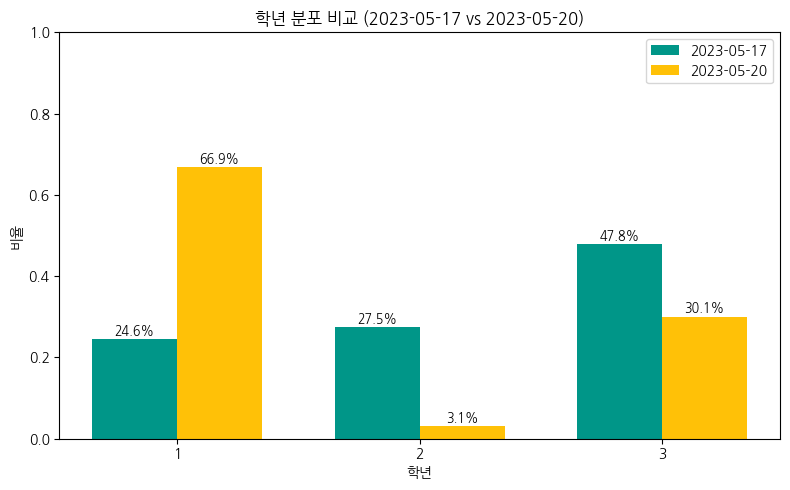

In [44]:


# 스타일 설정
main_color = "#009688"  
accent_color = "#ffc107" 

x = np.arange(len(grade_compare))  
bar_width = 0.35

plt.figure(figsize=(8, 5))

# 막대 그래프
plt.bar(x - bar_width/2, grade_compare["0517"], width=bar_width, label="2023-05-17", color=main_color)
plt.bar(x + bar_width/2, grade_compare["0520"], width=bar_width, label="2023-05-20", color=accent_color)

# 라벨 및 축 설정
plt.xticks(x, grade_compare["grade"].astype(int))
plt.xlabel("학년")
plt.ylabel("비율")
plt.title("학년 분포 비교 (2023-05-17 vs 2023-05-20)")
plt.legend()
plt.ylim(0, 1)

# 값 표시
for i in range(len(x)):
    plt.text(x[i] - bar_width/2, grade_compare["0517"][i] + 0.01,
             f'{grade_compare["0517"][i]*100:.1f}%', ha='center', fontsize=9)
    plt.text(x[i] + bar_width/2, grade_compare["0520"][i] + 0.01,
             f'{grade_compare["0520"][i]*100:.1f}%', ha='center', fontsize=9)

plt.tight_layout()
plt.show()


# 내가 투표 대상으로 선택한 사람 수 평균 

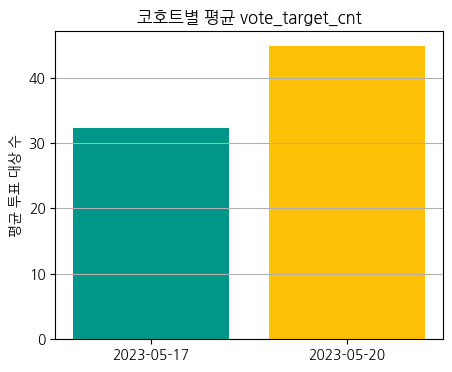

In [45]:
# 평균값 비교
avg_vote_target_0517 = cohort_0517_df["vote_target_cnt"].mean()
avg_vote_target_0520 = cohort_0520_df["vote_target_cnt"].mean()

# 막대그래프 시각화
plt.figure(figsize=(5, 4))
plt.bar(["2023-05-17", "2023-05-20"],
        [avg_vote_target_0517, avg_vote_target_0520],
        color=["#009688", "#ffc107"])
plt.ylabel("평균 투표 대상 수")
plt.title("코호트별 평균 vote_target_cnt")
plt.grid(axis="y")
plt.show()



# 친구 수

In [46]:
# 평균 친구 수 계산
mean_friend_cnt_0517 = cohort_0517_df["friend_cnt"].mean()
mean_friend_cnt_0520 = cohort_0520_df["friend_cnt"].mean()


In [47]:
mean_friend_df = pd.DataFrame({
    "cohort": ["0517", "0520"],
    "mean_friend_cnt": [mean_friend_cnt_0517, mean_friend_cnt_0520]
})

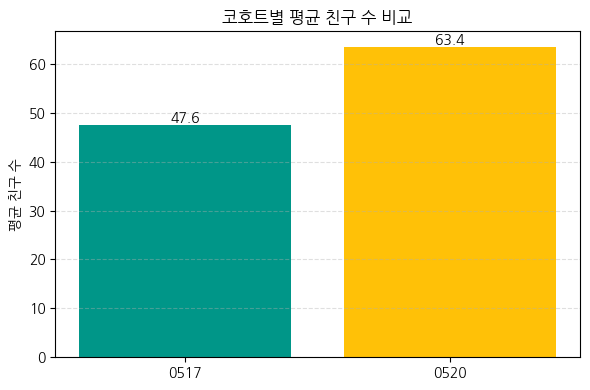

In [48]:
plt.figure(figsize=(6, 4))
plt.bar(mean_friend_df["cohort"], mean_friend_df["mean_friend_cnt"], color=["#009688", "#ffc107"])

# 수치 라벨
for i, v in enumerate(mean_friend_df["mean_friend_cnt"]):
    plt.text(i, v + 0.5, f"{v:.1f}", ha='center', fontsize=10)

plt.title("코호트별 평균 친구 수 비교")
plt.ylabel("평균 친구 수")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


# 평균 신고 수 

In [49]:
mean_report_cnt_0517 = cohort_0517_df["report_cnt"].mean()
mean_report_cnt_0520 = cohort_0520_df["report_cnt"].mean()

In [50]:
rate_reported_0517 = (cohort_0517_df["report_cnt"] > 0).mean()
rate_reported_0520 = (cohort_0520_df["report_cnt"] > 0).mean()


In [51]:
cohort_0517_df["report_cnt"].value_counts()

report_cnt
0    66
1     2
4     1
Name: count, dtype: int64

In [53]:
cohort_0520_df["report_cnt"].value_counts()

report_cnt
0    160
1      3
Name: count, dtype: int64

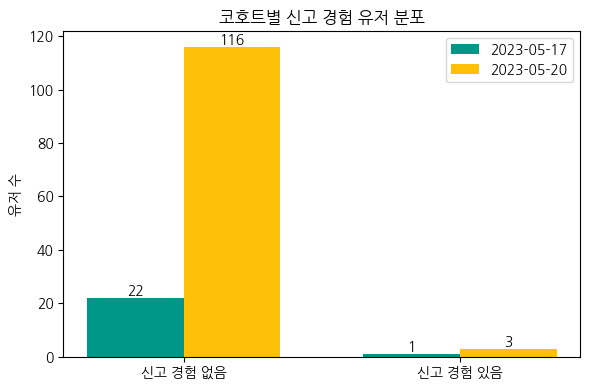

In [55]:
labels = ["신고 경험 없음", "신고 경험 있음"]
counts_0517 = [22, 1]
counts_0520 = [116, 3]

x = [0, 1]
bar_width = 0.35

plt.figure(figsize=(6, 4))
bars_0517 = plt.bar([i - bar_width/2 for i in x], counts_0517, width=bar_width, label="2023-05-17", color="#009688")
bars_0520 = plt.bar([i + bar_width/2 for i in x], counts_0520, width=bar_width, label="2023-05-20", color="#ffc107")

# 수치 라벨 추가
for i, bar in enumerate(bars_0517):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, str(counts_0517[i]), ha='center', fontsize=10)
for i, bar in enumerate(bars_0520):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, str(counts_0520[i]), ha='center', fontsize=10)

plt.xticks(x, labels)
plt.ylabel("유저 수")
plt.title("코호트별 신고 경험 유저 분포")
plt.legend()
plt.tight_layout()
plt.show()



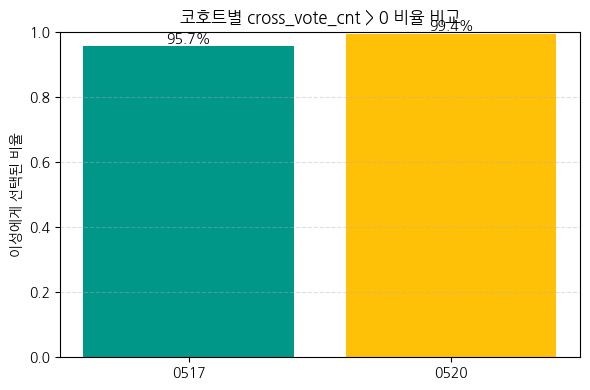

In [56]:
# 이성에게 선택된 적이 있는 유저 비율
cross_vote_0517_rate = (cohort_0517_df["cross_vote_cnt"] > 0).mean()
cross_vote_0520_rate = (cohort_0520_df["cross_vote_cnt"] > 0).mean()

# 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
bars = plt.bar(["0517", "0520"],
               [cross_vote_0517_rate, cross_vote_0520_rate],
               color=["#009688", "#ffc107"])

# 수치 표시
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{height*100:.1f}%", ha='center', fontsize=10)

plt.ylabel("이성에게 선택된 비율")
plt.title("코호트별 cross_vote_cnt > 0 비율 비교")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


In [57]:
print("0517 - cross_vote_cnt == 0:", (cohort_0517_df["cross_vote_cnt"] == 0).sum())
print("0520 - cross_vote_cnt == 0:", (cohort_0520_df["cross_vote_cnt"] == 0).sum())


0517 - cross_vote_cnt == 0: 3
0520 - cross_vote_cnt == 0: 1


In [58]:
cohort_0517_df["cross_vote_cnt"] 

50453     116
221862     15
242811     37
287502     17
297638      0
         ... 
473142    293
473683     54
473821     12
473895     98
475686    108
Name: cross_vote_cnt, Length: 69, dtype: int64

In [59]:
cohort_0520_df["cross_vote_cnt"] 

13343     191
31840      22
34356      71
35669     128
35873      40
         ... 
521070     41
521410     81
521446    178
521702    212
522285    107
Name: cross_vote_cnt, Length: 163, dtype: int64

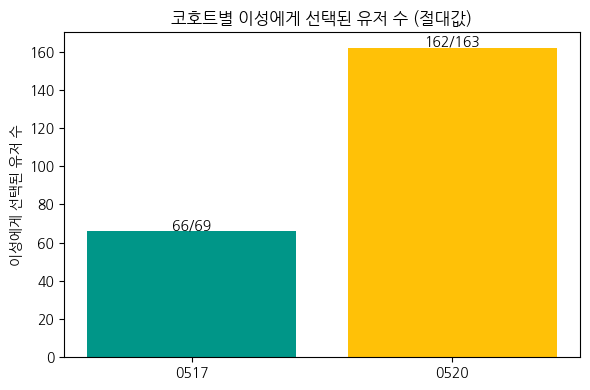

In [60]:
selected_0517 = (cohort_0517_df["cross_vote_cnt"] > 0).sum()
selected_0520 = (cohort_0520_df["cross_vote_cnt"] > 0).sum()

total_0517 = len(cohort_0517_df)
total_0520 = len(cohort_0520_df)

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
bars = plt.bar(["0517", "0520"], [selected_0517, selected_0520], color=["#009688", "#ffc107"])

for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2,
             bar.get_height() + 1,
             f"{bar.get_height()}/{[total_0517, total_0520][i]}",
             ha='center', fontsize=10)

plt.ylabel("이성에게 선택된 유저 수")
plt.title("코호트별 이성에게 선택된 유저 수 (절대값)")
plt.tight_layout()
plt.show()
